<a href="https://colab.research.google.com/github/tdekelver-bd/Intro-to-DL-BD-2023/blob/main/intro-dl-day2-3-Kaggle-PharmaCovigilance_hf_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [20]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [22]:
import transformers

print(transformers.__version__)

4.27.3


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/text-classification).

# Fine-tuning a model on a text classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a text classification task of the [GLUE Benchmark](https://gluebenchmark.com/).

![Widget inference on a text classification task](images/text_classification.png)


We will see how to easily load the dataset for each one of those tasks and use the `Trainer` API to fine-tune a model on it. Each task is named by its acronym, with `mnli-mm` standing for the mismatched version of MNLI (so same training set as `mnli` but different validation and test sets):

This notebook is built to run on any of the tasks in the list above, with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a classification head. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [23]:
task = "Servier-scibert-warmup"
model_checkpoint = "allenai/scibert_scivocab_uncased"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [24]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from datasets import load_dataset, load_metric, DatasetDict, Dataset
import evaluate
import pandas as pd
import numpy as np

In [26]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])


The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set (with more keys for the mismatched validation and test set in the special case of `mnli`).

In [27]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [28]:
df = pd.read_csv('/gdrive/MyDrive/BD/Servier_detection_PV/train.csv', sep=',')
df.head()

,id,text,label,file,authors,title,journals,sources,keywords,abstract,BERT_txt
0,0,"Li, Gang, Dr., Hu R\nConcerns about diuretics ...",1,alertePV-20211102.docx,"Li, Gang, Dr., Hu R",Concerns about diuretics as the first-line tre...,Aging and disease 2021 Oct 1; 12(7):1541–2,EMBASE - Language : English,7085441; 77083524; 77083535; aged indapamide t...,NaN,[TITLE] Concerns about diuretics as the first-...
1,1,"Fathi AT, Stein EM, DiNardo CD, Levis MJ, Mont...",1,alertePV-20211102.docx,"Fathi AT, Stein EM, DiNardo CD, Levis MJ, Mont...",Differentiation syndrome with lower-intensity ...,American journal of hematology 2021 Jun 1; 96(...,EMBASE - Language : English,1254053843; 1380288889; 155099; 1650550256; 23...,Differentiation Syndrome (DS) has been identif...,[TITLE] Differentiation syndrome with lower-in...
2,2,"Boulouiz S, Kossir A, Mouedder F, Miri C, Isma...",1,alertePV-20211102.docx,"Boulouiz S, Kossir A, Mouedder F, Miri C, Isma...",Shone syndrome revealed by treatment-resistant...,Annals of Medicine and Surgery November 2021; ...,EMBASE - Language : English,amlodipine plus indapamide plus perindopril ni...,Introduction: and importance: Shone complex is...,[TITLE] Shone syndrome revealed by treatment-r...
3,3,"Gyenes, Michelle, MSc\nPharmacotherapy in beha...",1,alertePV-20211102.docx,"Gyenes, Michelle, MSc",Pharmacotherapy in behavioral variant frontote...,Annals of Neurology October 2021; 90(SUPPL 27)...,EMBASE - Language : English,25332392; 303491; 34911552; 41100521; 51052621...,Background: Behavioral variant frontotemporal ...,[TITLE] Pharmacotherapy in behavioral variant ...
4,4,"Ball B, Mei M, Otoukesh S, Stein A\nCurrent an...",1,alertePV-20211102.docx,"Ball B, Mei M, Otoukesh S, Stein A",Current and Emerging Therapies for Acute Myelo...,Cancer Treatment and Research 2021; 181:57–73,EMBASE - Language : English,1254053843; 1650550256; 20830813; 2266582925; ...,Acute myeloid leukemia (AML) is predominantly ...,[TITLE] Current and Emerging Therapies for Acu...


In [29]:
df.to_json("dataset.jsonl", orient="records", lines=True)

In [30]:
dataset = load_dataset("json", data_files="dataset.jsonl")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-ceae01c8e9557b5b/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
# no train-test provided, so we create our own
# 80% train, 20% validation
train_testvalid = dataset['train'].train_test_split(seed=123, test_size=0.20)
# gather everyone if you want to have a single DatasetDict
all_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'valid': train_testvalid['test']})

In [32]:
all_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'file', 'authors', 'title', 'journals', 'sources', 'keywords', 'abstract', 'BERT_txt'],
        num_rows: 2632
    })
    valid: Dataset({
        features: ['id', 'text', 'label', 'file', 'authors', 'title', 'journals', 'sources', 'keywords', 'abstract', 'BERT_txt'],
        num_rows: 658
    })
})

To access an actual element, you need to select a split first, then give an index:

In [33]:
all_dataset["train"][0]

{'id': 936,
 'text': 'Vallejo M, Rives V, Hauch O\nPOSB116 Budget Impact Analysis of Pegaspargase in Acute Lymphoblastic Leukemia in Spain\nValue in Health January 2022; 25(1):Supplement, pp\nSource : EMBASE - Language : English\nKeywords : 1349719227; asparaginase asparaginase macrogol endogenous compound; (asparaginase macrogol) 130167690; (asparaginase) 9015683\n\nAbstract : Objectives: Acute lymphoblastic leukemia (ALL) is a rare, acute, rapidly progressing, and life-threatening form of cancer involving lymphoblasts. Pegaspargase, in which the immunogenicity of the native E.coli asparaginase enzyme is masked by conjugation with a polyethylene glycol group, has equivalent event free survival and overall survival as native E.coli asparaginase, elicits fewer hypersensitivity reactions necessitating an treatment switch to Erwinia derived asparaginase (Erwinase.RTM.) and requires fewer injections. This research aims to evaluate the Budget Impact/savings of pegaspargase in ALL in pediatr

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [34]:
clf_metrics.evaluation_module_names

['accuracy', 'f1', 'precision', 'recall']

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [35]:
from transformers import AutoTokenizer

if model_checkpoint == 'kamalkraj/biogpt':
    from transformers import BioGptTokenizer
    tokenizer = BioGptTokenizer.from_pretrained(model_checkpoint, use_fast=True)
elif model_checkpoint == 'michiyasunaga/bio-dragon':
    tokenizer = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract', use_fast=True)
else:  
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [36]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [102, 29423, 30112, 422, 238, 482, 8517, 3190, 103, 137, 238, 8517, 9289, 190, 256, 205, 103], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

We can then write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model.

In [37]:
def preprocess_function(examples):
    tokens = tokenizer(examples['BERT_txt'], truncation=True, max_length=512)
    return tokens

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [38]:
preprocess_function(all_dataset['train'][:5])

{'input_ids': [[102, 260, 10037, 1901, 495, 30125, 17828, 9600, 2141, 669, 131, 10850, 7714, 664, 297, 121, 3325, 2939, 21405, 9832, 121, 9852, 205, 260, 3628, 1901, 6454, 862, 3325, 2939, 21405, 9832, 145, 355, 546, 165, 106, 4346, 422, 3325, 422, 5450, 5180, 140, 422, 137, 1994, 579, 27918, 592, 131, 1314, 5005, 2939, 15478, 205, 10850, 7714, 664, 297, 422, 121, 334, 111, 27792, 131, 111, 6227, 139, 205, 5703, 2287, 4522, 10794, 297, 3823, 165, 23270, 214, 19071, 190, 106, 19736, 11976, 583, 422, 434, 3552, 2607, 2159, 2842, 137, 2103, 2842, 188, 6227, 139, 205, 5703, 2287, 4522, 10794, 297, 422, 15945, 30113, 7060, 19056, 12158, 4649, 1956, 17642, 130, 922, 6216, 147, 17763, 4983, 30110, 2865, 2287, 4522, 10794, 297, 145, 17763, 15203, 205, 3483, 30119, 205, 546, 137, 2978, 7060, 11397, 205, 238, 849, 7415, 147, 3138, 111, 9600, 2141, 1352, 12042, 131, 10850, 7714, 664, 297, 121, 355, 121, 6946, 137, 3873, 568, 121, 9852, 422, 188, 106, 2332, 131, 821, 711, 12953, 922, 2929, 205, 11

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [39]:
encoded_dataset = all_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2632 [00:00<?, ? examples/s]

Map:   0%|          | 0/658 [00:00<?, ? examples/s]

In [40]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'file', 'authors', 'title', 'journals', 'sources', 'keywords', 'abstract', 'BERT_txt', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2632
    })
    valid: Dataset({
        features: ['id', 'text', 'label', 'file', 'authors', 'title', 'journals', 'sources', 'keywords', 'abstract', 'BERT_txt', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 658
    })
})

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `AutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2, except for STS-B which is a regression problem and MNLI where we have 3 labels):

In [41]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
if model_checkpoint == 'kamalkraj/biogpt':
    from transformers import BioGptForCausalLM
    model = BioGptForCausalLM.from_pretrained(model_checkpoint, num_labels=num_labels)
else:
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [67]:
metric_name = "f1"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-{task}-new",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1, 
    lr_scheduler_type='cosine', 
    fp16=True,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
    report_to='mlflow'
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-mrpc"` or `"huggingface/bert-finetuned-mrpc"`).

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B):

In [66]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return clf_metrics.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [44]:
!databricks configure --host https://adb-2204706796872331.11.azuredatabricks.net/ 

Username: tdekelver@adflux.net
Password: 
Repeat for confirmation: 


In [45]:
from transformers.integrations import MLflowCallback
import mlflow

In [46]:
EXP_NAME = '/Users/tdekelver@adflux.net/Servier/Classification_AlertePV'
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment(EXP_NAME)

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1879877665261424', creation_time=1669035425281, experiment_id='1879877665261424', last_update_time=1680014046768, lifecycle_stage='active', name='/Users/tdekelver@adflux.net/Servier/Classification_AlertePV', tags={'mlflow.experiment.sourceName': '/Users/tdekelver@adflux.net/Servier/Classification_AlertePV',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'tdekelver@adflux.net',
 'mlflow.ownerId': '5802227064016709'}>

In [47]:
import os
os.environ['HF_MLFLOW_LOG_ARTIFACTS'] = '0'
os.environ['MLFLOW_EXPERIMENT_NAME'] = EXP_NAME
os.environ['MLFLOW_NESTED_RUN'] = '0'

In [68]:
validation_key = "valid"
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
#     callbacks=[MLflowCallback]
  )

You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

We can now finetune our model by just calling the `train` method:

In [69]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.839873,0.734043,0.697755,0.559557,0.926606
2,No log,0.587571,0.838906,0.760181,0.750000,0.770642
3,No log,0.633462,0.849544,0.770302,0.779343,0.761468
4,0.179000,0.806670,0.825228,0.763860,0.691450,0.853211
5,0.179000,0.782903,0.829787,0.761702,0.710317,0.821101


TrainOutput(global_step=825, training_loss=0.13363094907818418, metrics={'train_runtime': 589.111, 'train_samples_per_second': 22.339, 'train_steps_per_second': 1.4, 'total_flos': 3462541488537600.0, 'train_loss': 0.13363094907818418, 'epoch': 5.0})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [70]:
trainer.evaluate(encoded_dataset["valid"], metric_key_prefix='valid')

{'valid_loss': 0.6334620714187622,
 'valid_accuracy': 0.8495440729483282,
 'valid_f1': 0.7703016241299304,
 'valid_precision': 0.7793427230046949,
 'valid_recall': 0.7614678899082569,
 'valid_runtime': 8.6687,
 'valid_samples_per_second': 75.905,
 'valid_steps_per_second': 4.845,
 'epoch': 5.0}

In [71]:
df_blind = pd.read_csv('/gdrive/MyDrive/BD/Servier_detection_PV/test_blind.csv', sep=',')
df_blind.head()

,id,text,file,authors,title,journals,sources,keywords,abstract,BERT_txt
0,43,"Chanmanee T, Wongpun J, Tocharus C, Govitrapon...",alertePV-20211102.docx,"Chanmanee T, Wongpun J, Tocharus C, Govitrapon...",The effects of agomelatine on endoplasmic reti...,Chemico-biological interactions 2021; 351:109703,MEDLINE (EPUB AHEAD OF PRINT) - Language : Eng...,NaN,"BACKGROUND: Agomelatine, a novel antidepressan...",[TITLE] The effects of agomelatine on endoplas...
1,49,Rafehi S\n[With antihypertensive drugs against...,alertePV-20211102.docx,Rafehi S,[With antihypertensive drugs against dementia:...,Deutsche Apotheker Zeitung 2021; 161(38. arn. ...,EMBASE - Language : German,83915837; 85441618; 98048976; 99149834; antihy...,NaN,[TITLE] [With antihypertensive drugs against d...
2,59,"Engels M, Rahmati S, Kovermann P, Gensch T, Fa...",alertePV-20211102.docx,"Engels M, Rahmati S, Kovermann P, Gensch T, Fa...",Glial Chloride Homeostasis Under Transient Isc...,Frontiers in cellular neuroscience 2021 Sep 16...,EMBASE - Language : English,138158; 14092945; 2 amino 5; 56655; 56860; 6; ...,High water permeabilities permit rapid adjustm...,[TITLE] Glial Chloride Homeostasis Under Trans...
3,61,"Micaglio E, Locati ET, Monasky MM, Romani F, P...",alertePV-20211102.docx,"Micaglio E, Locati ET, Monasky MM, Romani F, P...",Role of Pharmacogenetics in Adverse Drug React...,Frontiers in pharmacology 2021 Apr 30; 12. arn...,EMBASE - Language : English,10347816; 11006272; 115103554; 117772700; 1200...,Adverse drug reactions (ADRs) are an important...,[TITLE] Role of Pharmacogenetics in Adverse Dr...
4,69,"Shahidullah M, Mandal A, Delamere NA\nTRPV1-de...",alertePV-20211102.docx,"Shahidullah M, Mandal A, Delamere NA",TRPV1-dependent NKCC1 activation in mouse lens...,IOVS JUN 2021; 62(8):2058,BIOSIS - Language : English,404864 (capsaicin) 7440177 (rubidium) 33069624...,Purpose : In earlier studies we showed the res...,[TITLE] TRPV1-dependent NKCC1 activation in mo...


In [72]:
ds_blind = Dataset.from_pandas(df_blind)

In [73]:
encoded_blind_dataset = ds_blind.map(preprocess_function, batched=True)

Map:   0%|          | 0/471 [00:00<?, ? examples/s]

In [74]:
encoded_blind_dataset

Dataset({
    features: ['id', 'text', 'file', 'authors', 'title', 'journals', 'sources', 'keywords', 'abstract', 'BERT_txt', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 471
})

You can now upload the result of the training to the Hub, just execute this instruction:

In [75]:
y_pred = trainer.predict(encoded_blind_dataset)

In [76]:
y_pred.predictions.shape

(471, 2)

In [77]:
y_pred.predictions[:5]

array([[ 0.7305, -0.784 ],
       [ 2.225 , -2.06  ],
       [ 3.2   , -3.5   ],
       [-2.982 ,  3.219 ],
       [ 2.791 , -3.227 ]], dtype=float16)

In [78]:
np.argmax(y_pred.predictions, axis=1)[:5]

array([0, 0, 0, 1, 0])

In [79]:
submission = pd.DataFrame({'id': df_blind['id'], 'label': np.argmax(y_pred.predictions, axis=1)})
submission.to_csv('new_submission.csv', index=False)

- Score on public leaderboard: **0.83050**
- Score on private leaderboard: **0.84615**

# checking on test set (with labels)

In [80]:
df_test = pd.read_csv('/gdrive/MyDrive/BD/Servier_detection_PV/test_label.csv', sep=',')
df_test.head()

,id,label
0,43,0
1,49,0
2,59,0
3,61,0
4,69,0


In [81]:
df_test = df_test.rename(columns={'label': 'predicted'}).merge(submission, on='id')
print('Shape: ' + str(df_test.shape))
df_test.head()

Shape: (471, 3)


,id,predicted,label
0,43,0,0
1,49,0,0
2,59,0,0
3,61,0,1
4,69,0,0


In [82]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_preds = df_test.predicted
y_true = df_test.label
cm = confusion_matrix(y_true, y_preds)
cm

array([[263,  39],
       [ 33, 136]])

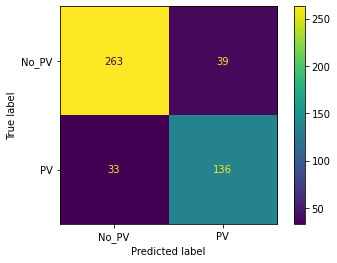

In [83]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['No_PV', 'PV'])
cmd.plot()
plt.savefig('confusionmatrix.png')

Saving model

In [84]:
trainer.save_model(f'./{task}')

Uploading model & confusion matrix to mlflow

In [85]:
try:
    mlflow.end_run()
except:
    print('run not active -> continuing')
run = mlflow.start_run(run_id='ee15599d9050499d9317d54faaf45064', nested=False)
# Imports PIL module
from PIL import Image
im = Image.open('confusionmatrix.png')
mlflow.log_image(im, 'confusionmatrix.png')
mlflow.log_artifacts(task, artifact_path='model-' + task)
mlflow.end_run()

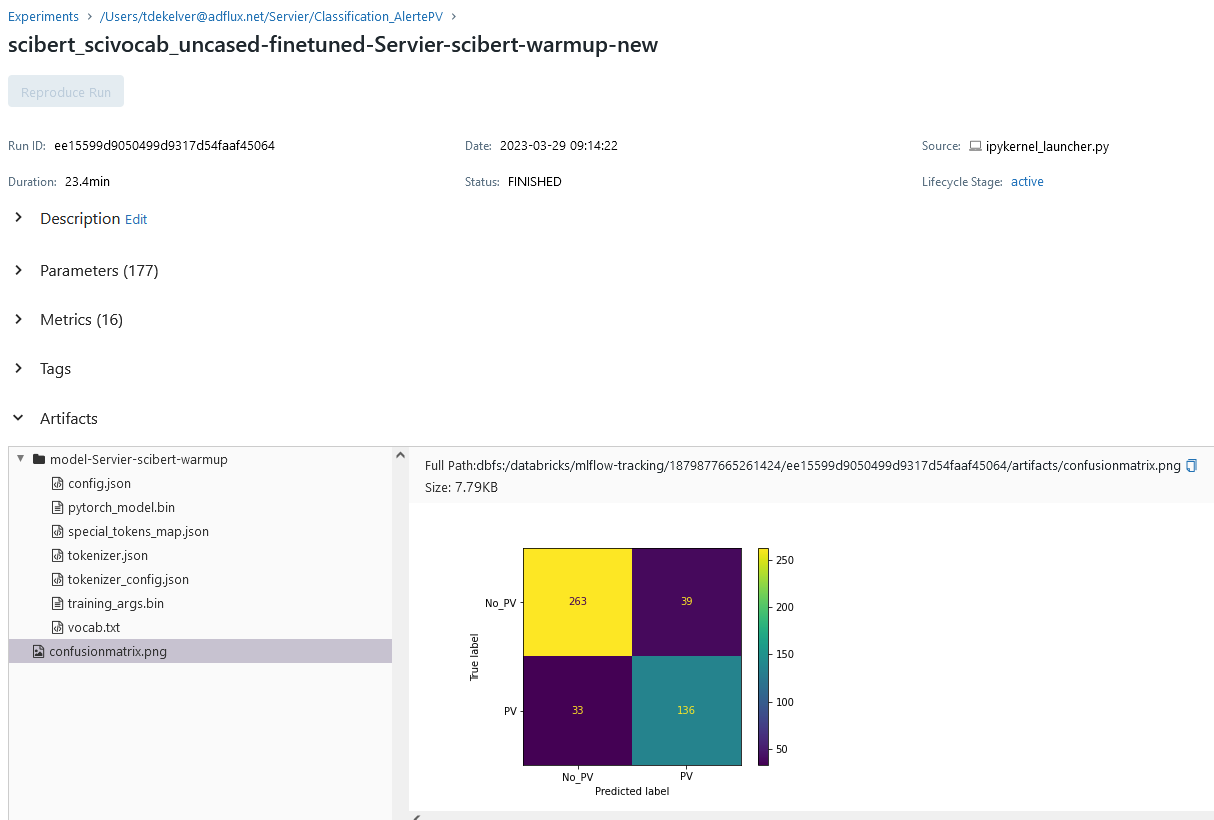